In [2]:
# Step 1: Web scrape Wikipedia page for Netherlands

import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import streamlit as st
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Abhinav\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Abhinav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Step 1: Web scrape Wikipedia page for Netherlands
url = "https://en.wikipedia.org/wiki/Mexico"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

In [5]:
print(f"Response Status: {response.status_code}")
print(f"Page Title: {soup.title.string}")

Response Status: 200
Page Title: Mexico - Wikipedia


In [6]:
# Step 2: Scrape only text
# Get all paragraphs from the main content
paragraphs = []

# Find the main content area
content_div = soup.find("div", {"id": "mw-content-text"})
if content_div:
    # Get all paragraphs within the main content area
    for p in content_div.find_all("p"):
        if p.text.strip():
            paragraphs.append(p.text)

# Combine all paragraphs into one text
raw_text = ' '.join(paragraphs)

print(f"Total characters extracted: {len(raw_text)}")
print(f"Preview of the text: {raw_text[:500]}...")

Total characters extracted: 99778
Preview of the text: Mexico,[a][b] officially the United Mexican States (Spanish: Los Estados Unidos Mexicanos),[c] is a country in North America. It borders the United States to the north, and Guatemala and Belize to the southeast; while having maritime boundaries with the Pacific Ocean to the west, the Caribbean Sea to the southeast, and the Gulf of Mexico to the east. Mexico covers 1,972,550 km2 (761,610 sq mi),[12] and is the thirteenth-largest country in the world by land area. With a population exceeding 130 m...


In [7]:
# Step 3: Clean Text and preprocessing
def clean_text(text):
    # Remove citations [1], [2], etc.
    text = re.sub(r'\[\d+\]', '', text)
    # Remove special characters and digits
    text = re.sub(r'[^\w\s.]', '', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

cleaned_text = clean_text(raw_text)

print(f"Total characters after cleaning: {len(cleaned_text)}")
print(f"Preview of the cleaned text: {cleaned_text[:500]}...")

Total characters after cleaning: 95634
Preview of the cleaned text: Mexicoab officially the United Mexican States Spanish Los Estados Unidos Mexicanosc is a country in North America. It borders the United States to the north and Guatemala and Belize to the southeast while having maritime boundaries with the Pacific Ocean to the west the Caribbean Sea to the southeast and the Gulf of Mexico to the east. Mexico covers 1972550 km2 761610 sq mi and is the thirteenthlargest country in the world by land area. With a population exceeding 130 million Mexico is the tenth...


In [8]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Abhinav\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [9]:
# Step 4: Use Sentence Tokenizer and sentence tokenize
sentences = sent_tokenize(cleaned_text)
print(f"Total number of sentences: {len(sentences)}")
print(f"First 5 sentences:")
for i, sent in enumerate(sentences[:5]):
    print(f"{i+1}. {sent}")

Total number of sentences: 633
First 5 sentences:
1. Mexicoab officially the United Mexican States Spanish Los Estados Unidos Mexicanosc is a country in North America.
2. It borders the United States to the north and Guatemala and Belize to the southeast while having maritime boundaries with the Pacific Ocean to the west the Caribbean Sea to the southeast and the Gulf of Mexico to the east.
3. Mexico covers 1972550 km2 761610 sq mi and is the thirteenthlargest country in the world by land area.
4. With a population exceeding 130 million Mexico is the tenthmost populous country in the world and is home to the largest number of native Spanish speakers.
5. Mexico City is the capital and largest city which ranks among the most populous metropolitan areas in the world.


In [10]:
# Step 5: Use TextBlob and analyze_sentiment() function to calculate sentiment of sentences
def get_sentiment(sentence):
    analysis = TextBlob(sentence)
    polarity = analysis.sentiment.polarity
    
    if polarity > 0.1:
        return 'positive'
    elif polarity < -0.1:
        return 'negative'
    else:
        return 'neutral'
    
# Calculate sentiment for each sentence
sentiment_results = []
for sentence in sentences:
    blob = TextBlob(sentence)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    sentiment = get_sentiment(sentence)
    
    sentiment_results.append({
        'sentence': sentence,
        'polarity': polarity,
        'subjectivity': subjectivity,
        'sentiment': sentiment
    })

Dataframe shape: (633, 4)

First 5 rows of the sentiment dataframe:
                                            sentence  polarity  subjectivity  \
0  Mexicoab officially the United Mexican States ...       0.0           0.0   
1  It borders the United States to the north and ...       0.0           0.0   
2  Mexico covers 1972550 km2 761610 sq mi and is ...       0.0           0.0   
3  With a population exceeding 130 million Mexico...       0.0           0.0   
4  Mexico City is the capital and largest city wh...       0.5           0.5   

  sentiment  
0   neutral  
1   neutral  
2   neutral  
3   neutral  
4  positive  

Sentiment distribution:
sentiment
neutral     425
positive    171
negative     37
Name: count, dtype: int64


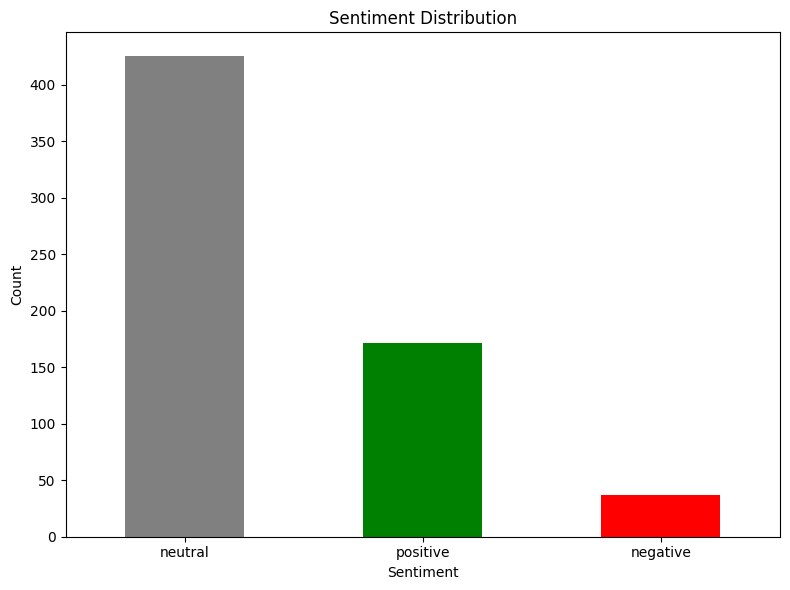

In [11]:
# Step 6: Create a dataframe of sentences and sentiment
sentiment_df = pd.DataFrame(sentiment_results)

print(f"Dataframe shape: {sentiment_df.shape}")
print("\nFirst 5 rows of the sentiment dataframe:")
print(sentiment_df.head())

print("\nSentiment distribution:")
print(sentiment_df['sentiment'].value_counts())

# Visualize sentiment distribution
plt.figure(figsize=(8, 6))
sentiment_df['sentiment'].value_counts().plot(kind='bar', color=['gray', 'green', 'red'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [12]:
# Step 7: Word tokenize the text data
words = word_tokenize(cleaned_text.lower())
print(f"Total words found: {len(words)}")
print(f"First 20 words: {words[:20]}")

Total words found: 15595
First 20 words: ['mexicoab', 'officially', 'the', 'united', 'mexican', 'states', 'spanish', 'los', 'estados', 'unidos', 'mexicanosc', 'is', 'a', 'country', 'in', 'north', 'america', '.', 'it', 'borders']


In [13]:
# Step 8: Remove stopwords
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word.isalpha() and word not in stop_words]

print(f"Words after removing stopwords: {len(filtered_words)}")
print(f"First 20 filtered words: {filtered_words[:20]}")

Words after removing stopwords: 8550
First 20 filtered words: ['mexicoab', 'officially', 'united', 'mexican', 'states', 'spanish', 'los', 'estados', 'unidos', 'mexicanosc', 'country', 'north', 'america', 'borders', 'united', 'states', 'north', 'guatemala', 'belize', 'southeast']


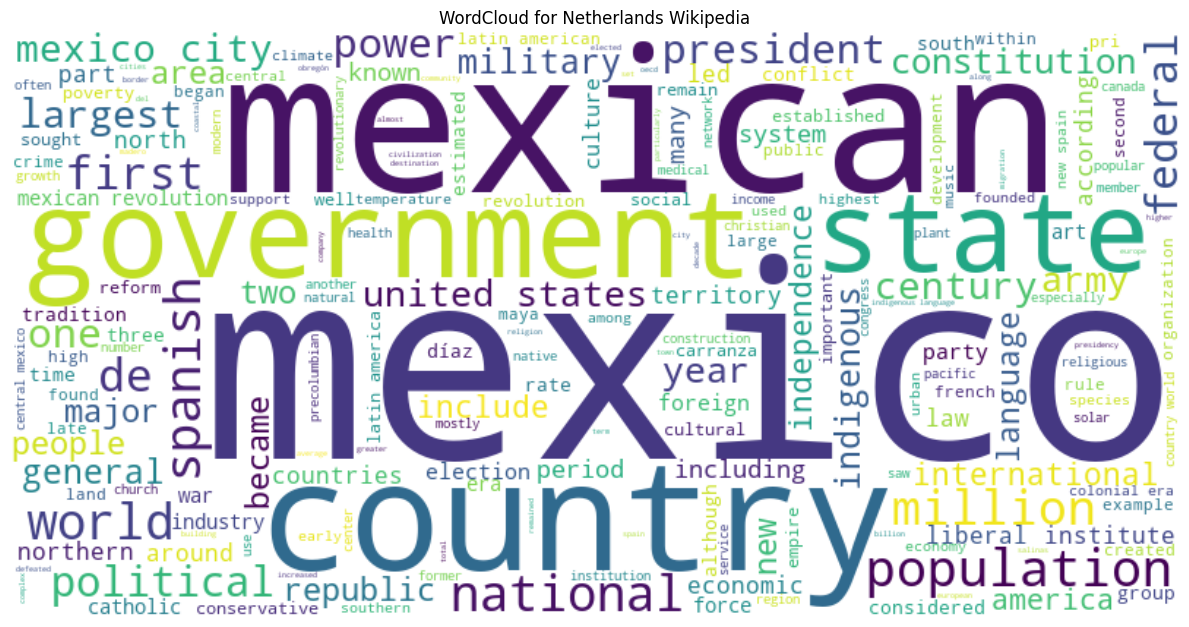

In [14]:
# Step 9: Wordcloud of data
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(filtered_words))

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Netherlands Wikipedia')
plt.tight_layout()
plt.show()

Top 20 frequent words:
mexico: 243
mexican: 111
country: 50
world: 42
government: 41
national: 39
million: 38
population: 37
mexicos: 37
states: 36
indigenous: 34
first: 34
spanish: 33
united: 32
city: 31
de: 29
new: 28
federal: 28
political: 27
state: 27


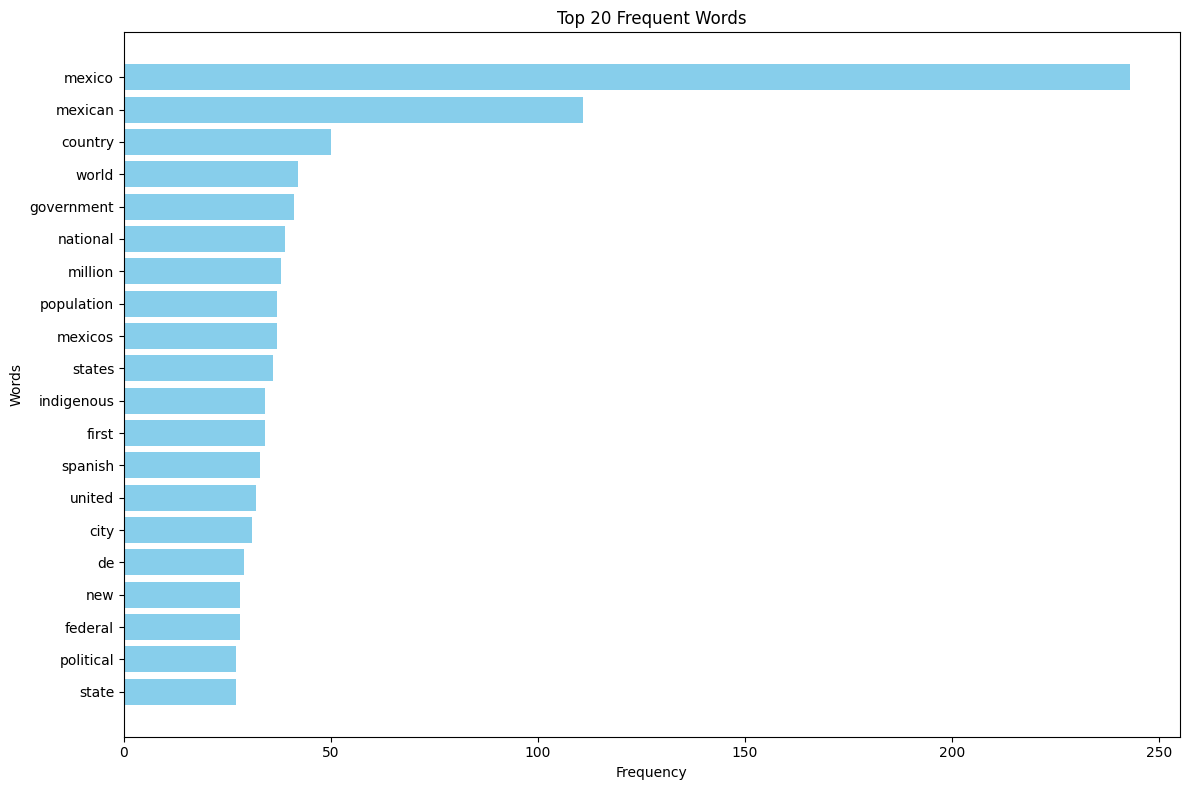

In [15]:
# Step 10: Frequent Words with frequency counts
word_freq = Counter(filtered_words)
common_words = word_freq.most_common(20)

print("Top 20 frequent words:")
for word, count in common_words:
    print(f"{word}: {count}")

# Visualize top 20 words
plt.figure(figsize=(12, 8))
words_df = pd.DataFrame(common_words, columns=['word', 'count'])
plt.barh(words_df['word'], words_df['count'], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Frequent Words')
plt.gca().invert_yaxis()  # To display the most frequent word at the top
plt.tight_layout()
plt.show()

In [16]:
# Step 11: Apply TFIDF Vectorizer on sentences and sentiment dataframe
# Step 12: Use only positive and negative sentiments only & ignore neutral
filtered_sentiment_df = sentiment_df[sentiment_df['sentiment'] != 'neutral']
print(f"Dataframe shape after removing neutral sentiments: {filtered_sentiment_df.shape}")
print(filtered_sentiment_df['sentiment'].value_counts())

# Prepare data for ML models
X = filtered_sentiment_df['sentence']
y = filtered_sentiment_df['sentiment']

# Convert text to TFIDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=2)
X_tfidf = tfidf_vectorizer.fit_transform(X)

print(f"TFIDF matrix shape: {X_tfidf.shape}")

Dataframe shape after removing neutral sentiments: (208, 4)
sentiment
positive    171
negative     37
Name: count, dtype: int64
TFIDF matrix shape: (208, 560)


In [17]:
# Step 13: Use SMOTE to balance sentiment
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Apply SMOTE for balancing
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", pd.Series(y_train).value_counts())
print("After SMOTE:", pd.Series(y_train_smote).value_counts())

Before SMOTE: sentiment
positive    133
negative     33
Name: count, dtype: int64
After SMOTE: sentiment
negative    133
positive    133
Name: count, dtype: int64


In [18]:
# Step 14: Build machine learning models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)
    print("-" * 80)
    
    return model

# a) Binary Logistic Regression
logreg_model = evaluate_model(
    LogisticRegression(max_iter=1000, random_state=42),
    X_train_smote, X_test, y_train_smote, y_test,
    "Logistic Regression"
)

# b) Decision Tree
dt_model = evaluate_model(
    DecisionTreeClassifier(random_state=42),
    X_train_smote, X_test, y_train_smote, y_test,
    "Decision Tree"
)

# c) Random Forest
rf_model = evaluate_model(
    RandomForestClassifier(n_estimators=100, random_state=42),
    X_train_smote, X_test, y_train_smote, y_test,
    "Random Forest"
)

# d) Gradient Boosting
gb_model = evaluate_model(
    GradientBoostingClassifier(n_estimators=100, random_state=42),
    X_train_smote, X_test, y_train_smote, y_test,
    "Gradient Boosting"
)

# e) Naïve Bayes
nb_model = evaluate_model(
    MultinomialNB(),
    X_train_smote, X_test, y_train_smote, y_test,
    "Naive Bayes"
)

# f) K Nearest Neighbors
knn_model = evaluate_model(
    KNeighborsClassifier(n_neighbors=5),
    X_train_smote, X_test, y_train_smote, y_test,
    "K-Nearest Neighbors"
)

# Choose the best performing model (for example, Logistic Regression)
# We'll use this model in our Streamlit app
best_model = logreg_model
print(f"Selected model for Streamlit app: Logistic Regression")

Model: Logistic Regression
Accuracy: 0.8571
Classification Report:
              precision    recall  f1-score   support

    negative       0.33      0.50      0.40         4
    positive       0.94      0.89      0.92        38

    accuracy                           0.86        42
   macro avg       0.64      0.70      0.66        42
weighted avg       0.89      0.86      0.87        42

--------------------------------------------------------------------------------
Model: Decision Tree
Accuracy: 0.6190
Classification Report:
              precision    recall  f1-score   support

    negative       0.07      0.25      0.11         4
    positive       0.89      0.66      0.76        38

    accuracy                           0.62        42
   macro avg       0.48      0.45      0.43        42
weighted avg       0.81      0.62      0.70        42

--------------------------------------------------------------------------------
Model: Random Forest
Accuracy: 0.8810
Classification Rep

In [19]:
# Save the vectorizer and model for the Streamlit app
import pickle

with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
    
with open('sentiment_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)